In [13]:
# flippers_linear_policy_iteration.py
# HJB (linear in Δ given a) + FV KFE fixed point
# Requires: numpy, scipy (sparse)
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# ------------------------------
# Utilities  (NumPy 2.0–safe)
# ------------------------------
def vec(M):  # column-major vectorization: (i over q) fastest
    # allow NumPy to copy if needed; enforce Fortran order for reshape
    return np.asarray(M, order="F").reshape(-1, order="F")

def unvec(v, n_q, n_d):
    return np.asarray(v).reshape((n_q, n_d), order="F")

def diagv(v):
    return sp.diags(np.asarray(v), 0, format="csc")


def kron(A, B):  # Kronecker, returns CSC
    return sp.kron(A, B, format="csc")

# ------------------------------
# Parameters & grids
# ------------------------------
class Params:
    def __init__(self):
        # Economics
        self.r = 0.04
        self.gamma = 0.15
        self.rho = 2.0
        self.d = 0.05
        self.kappa0 = 1.0
        self.s = 0.6  # owner mass

        # Domains
        self.qmin, self.qmax = 0.2, 1.0
        self.dmin, self.dmax = 0.0, 1.0

        # Grids
        self.Nq = 60
        self.Nd = 60

        # Algorithm
        self.theta_a = 0.25        # policy damping
        self.dt_kfe = 0.25          # implicit Euler step
        self.kfe_steps = 40        # steps per outer loop
        self.max_outer = 60
        self.tol = 1e-6
        self.include_swaps = False # rectangles off at start

def make_grids(p: Params):
    q = np.linspace(p.qmin, p.qmax, p.Nq)
    dlt = np.linspace(p.dmin, p.dmax, p.Nd)
    dq = (p.qmax - p.qmin) / (p.Nq - 1)
    dd = (p.dmax - p.dmin) / (p.Nd - 1)
    wq = np.full(p.Nq, dq)
    wd = np.full(p.Nd, dd)
    return q, dlt, dq, dd, wq, wd

# ------------------------------
# Primitive distributions
# ------------------------------
def stationary_g_delta(dlt):
    # Example: Beta(2,3) on [0,1]
    a, b = 2.0, 3.0
    from math import gamma as Gamma
    B = Gamma(a)*Gamma(b)/Gamma(a+b)
    g = (dlt - dlt.min())/(dlt.max()-dlt.min()+1e-16)
    g = (g**(a-1)) * ((1-g)**(b-1)) / B
    # normalize continuously
    g /= np.trapezoid(g, dlt)
    return g

# ------------------------------
# Discrete operators (q-derivatives)
# ------------------------------
def Dq_forward_last_backward(Nq, dq):
    # Forward in interior; last row one-sided backward (state-constraint)
    data, rows, cols = [], [], []
    for i in range(Nq):
        if i < Nq-1:
            rows += [i, i]
            cols += [i, i+1]
            data += [-1.0/dq, 1.0/dq]
        else:
            rows += [i, i]
            cols += [i-1, i]
            data += [-1.0/dq, 1.0/dq]
    return sp.csc_matrix((data, (rows, cols)), shape=(Nq, Nq))

# ------------------------------
# HJB assembly (linear in Δ given a, h0, h1)
# ------------------------------
def assemble_trade_kernels_h0(h0, wd):
    Nd = len(h0)
    rows, cols, data = [], [], []
    for j in range(Nd):
        for b in range(j, Nd):
            rows.append(j); cols.append(b); data.append(h0[b]*wd[b])
    U_h0 = sp.csc_matrix((data, (rows, cols)), shape=(Nd, Nd))
    eta = np.asarray(U_h0 @ np.ones(Nd))
    Eta = diagv(eta)
    return U_h0, Eta, eta

def assemble_trade_kernels_h1(h1, wq, wd):
    Nq, Nd = h1.shape
    Xi = np.cumsum(h1 * wd[None, :], axis=1)  # (Nq,Nd)
    blocks = [diagv(wq * Xi[:, j]) for j in range(Nd)]
    C_diag = sp.block_diag(blocks, format="csc")

    zero = sp.csc_matrix((Nq, Nq))
    L_blocks = [[None]*Nd for _ in range(Nd)]
    for j in range(Nd):
        for s in range(Nd):
            L_blocks[j][s] = diagv(wq * h1[:, s] * wd[s]) if s <= j else zero
    L_h1 = sp.bmat(L_blocks, format="csc")
    return C_diag, L_h1

def assemble_A_linear_HJB(p: Params, q, dlt, wq, wd, a, h0, h1, g):
    Nq, Nd = p.Nq, p.Nd

    # Derivative in q and slope operator
    dq = (q[-1]-q[0])/(Nq-1)
    Dq = Dq_forward_last_backward(Nq, dq)
    S = kron(sp.eye(Nd, format="csc"), Dq)  # (Nd ⊗ Dq)

    # Drift in q: -d q * Dq  -> I_d ⊗ (diag(-d q) @ Dq)
    A_drift = kron(sp.eye(Nd, format="csc"), diagv(-p.d * q) @ Dq)

    # Policy slope term: diag(a) S
    A_a = diagv(vec(a)) @ S

    # Type refreshing: I_q ⊗ gamma (I - E_g)
    e = np.ones(Nd)
    Eg = sp.csc_matrix(np.outer(e, g*wd))  # Nd x Nd sparse
    A_gamma = kron(sp.eye(Nq, format="csc"), p.gamma*(sp.eye(Nd, format="csc") - Eg))

    # Buyer-side (h0): I_q ⊗ (rho/2) (Eta - U_h0)
    U_h0, Eta, _ = assemble_trade_kernels_h0(h0, wd)
    A_h0 = kron(sp.eye(Nq, format="csc"), 0.5*p.rho*(Eta - U_h0))

    # Cross (h1): (rho/2) (C_diag - L_h1)
    C_diag, L_h1 = assemble_trade_kernels_h1(h1, wq, wd)
    A_h1 = 0.5*p.rho*(C_diag - L_h1)

    A = p.r*sp.eye(Nq*Nd, format="csc") + A_drift + A_a + A_gamma + A_h0 + A_h1

    # Flow vector b = vec(q*δ^T) - 0.5 * vec(kappa(q) * a^2)
    QQ, DD = np.meshgrid(q, dlt, indexing="ij")
    flow = QQ * DD
    kappa = p.kappa0 * QQ
    b = vec(flow) - 0.5*vec(kappa * (a**2))
    return A, b, S, kappa

# ------------------------------
# KFE assembly (finite-volume divergence + integral terms)
# ------------------------------
def fv_divergence_matrix(p: Params, q, a):
    Nq, Nd = p.Nq, p.Nd
    dq = (q[-1]-q[0])/(Nq-1)

    q_face = 0.5*(q[:-1] + q[1:])  # Nq-1
    v_face = 0.5*(a[:-1, :] + a[1:, :]) - p.d*q_face[:, None]

    blocks = []
    for j in range(Nd):
        rows, cols, data = [], [], []
        for i in range(Nq-1):
            v = v_face[i, j]
            if v >= 0:
                rows += [i, i+1]; cols += [i, i]; data += [-v/dq, +v/dq]
            else:
                rows += [i, i+1]; cols += [i+1, i+1]; data += [-v/dq, +v/dq]
        D_fv = sp.csc_matrix((data, (rows, cols)), shape=(Nq, Nq))
        blocks.append(D_fv)
    return sp.block_diag(blocks, format="csc")

def owners_KFE_generator(p: Params, q, dlt, wq, wd, a, h0, include_swaps=False, h1_for_rect=None):
    Nq, Nd = p.Nq, p.Nd
    D_fv = fv_divergence_matrix(p, q, a)  # transport in q

    # gamma*(g H1 - h1) operator
    g = stationary_g_delta(dlt)
    minus_gamma_I = kron(sp.eye(Nq, format="csc"), -p.gamma*sp.eye(Nd, format="csc"))
    rows, cols, data = [], [], []
    for i in range(Nq):
        for j in range(Nd):
            for s in range(Nd):
                rows.append(i + j*Nq)
                cols.append(i + s*Nq)
                data.append(p.gamma * g[j] * wd[s])
    A_gamma = sp.csc_matrix((data, (rows, cols)), shape=(Nq*Nd, Nq*Nd))

    # Trade with non-owners:
    # + rho diag(h0) L_delta  - rho diag(Bge)
    rows, cols, data = [], [], []
    for j in range(Nd):
        for s in range(j+1):
            coeff = p.rho * h0[j] * wd[s]
            for i in range(Nq):
                rows.append(i + j*Nq); cols.append(i + s*Nq); data.append(coeff)
    T1 = sp.csc_matrix((data, (rows, cols)), shape=(Nq*Nd, Nq*Nd))
    Bge = np.array([np.sum(h0[j:]*wd[j:]) for j in range(Nd)])
    T2 = - kron(sp.eye(Nq, format="csc"), diagv(p.rho*Bge))

    L1 = D_fv + A_gamma + minus_gamma_I + T1 + T2

    if include_swaps:
        assert h1_for_rect is not None, "Provide h1_for_rect when include_swaps=True."
        N = Nq*Nd
        R = sp.csc_matrix((N, N))
        Aij = np.zeros((Nq, Nd), order="F")
        for i in range(Nq):
            for j in range(Nd):
                Aij[i, j] = (p.qmax - q[i])*(p.dmax - dlt[j]) + (q[i] - p.qmin)*(dlt[j] - p.dmin)
        R = R - diagv(p.rho * vec(Aij))

        I1 = np.zeros((Nq, Nd), order="F")
        I2 = np.zeros((Nq, Nd), order="F")
        csum_low = np.cumsum(h1_for_rect * wd[None, :], axis=1)
        csum_up = np.cumsum(h1_for_rect[:, ::-1] * wd[::-1][None, :], axis=1)[:, ::-1]
        wq_from_i = np.flip(np.cumsum(np.flip(wq)))
        wq_to_i   = np.cumsum(wq)
        for i in range(Nq):
            I1[i, :] = wq_from_i[i] * csum_low[-1, :]
            I2[i, :] = wq_to_i[i]   * csum_up[0, :]
        rect_rhs = p.rho * vec(I1 + I2)
        return L1, rect_rhs
    else:
        rect_rhs = np.zeros(Nq*Nd)
        return L1, rect_rhs

# ------------------------------
# Non-owners KFE (frozen linearization)
# ------------------------------
def normalize_h1(p: Params, h1, wq, wd):
    mass = np.sum(h1 * wq[:, None] * wd[None, :])
    if mass <= 0: 
        return np.outer(np.ones(p.Nq)/(p.qmax-p.qmin), p.s*np.ones(p.Nd))
    return h1 * (p.s / mass)

def normalize_h0(p: Params, h0, wd):
    mass = np.sum(h0 * wd)
    if mass <= 0: 
        return np.full_like(h0, (1-p.s))
    return h0 * ((1-p.s) / mass)

# ------------------------------
# Solver
# ------------------------------
def solve_model(p: Params, verbose=True):
    q, dlt, dq, dd, wq, wd = make_grids(p)
    Nq, Nd = p.Nq, p.Nd

    # Initial guesses
    g = stationary_g_delta(dlt)
    h0 = (1-p.s) * g.copy()
    h1 = np.outer(np.ones(Nq)/(p.qmax-p.qmin), p.s * g)  # uniform in q, proportional to g in δ
    Delta = (q[:, None] * dlt[None, :]) / p.r
    a = np.zeros_like(Delta)

    for it in range(p.max_outer):
        # --- HJB (linear) given (a, h0, h1) ---
        A, b, S, kappa = assemble_A_linear_HJB(p, q, dlt, wq, wd, a, h0, h1, g)
        Delta_new = spla.spsolve(A, b)
        res_hjb = np.linalg.norm(A @ Delta_new - b, ord=np.inf) / (1 + np.linalg.norm(b, ord=np.inf))
        Delta = Delta_new

        # --- Policy improvement ---
        slope = S @ Delta
        slope = unvec(slope, Nq, Nd)
        anew = np.maximum(slope, 0.0) / (kappa + 1e-14)
        a = (1 - p.theta_a) * a + p.theta_a * anew

        # --- KFE (owners) ---
        L1, rect_rhs = owners_KFE_generator(
            p, q, dlt, wq, wd, a, h0,
            include_swaps=p.include_swaps,
            h1_for_rect=h1
        )
        I1 = sp.eye(Nq*Nd, format="csc")
        rhs = -rect_rhs
        h1v = vec(h1)
        for _ in range(p.kfe_steps):
            h1v = spla.spsolve(I1 - p.dt_kfe * L1, h1v + p.dt_kfe * rhs)
            h1 = unvec(h1v, Nq, Nd)
            h1 = normalize_h1(p, h1, wq, wd)
            h1v = vec(h1)

        # --- KFE (non-owners), freeze B^>= and T^<= from current h1 ---
        Q = np.sum(h1 * wq[:, None], axis=0)            # Nd
        Bge = np.array([np.sum(h0[j:]*wd[j:]) for j in range(Nd)])
        Tle = np.zeros(Nd)
        for j in range(Nd):
            Tle[j] = np.sum(wq[:, None] * np.cumsum(h1[:, :j+1]*wd[None, :j+1], axis=1))

        H0 = 1 - p.s
        L0 = -p.gamma*sp.eye(Nd, format="csc") - diagv(p.rho * Tle)
        rhs0 = -p.gamma * g * H0 - p.rho * (Q * Bge)
        h0 = spla.spsolve(L0, rhs0)
        h0 = np.maximum(h0, 1e-16)
        h0 = normalize_h0(p, h0, wd)

        # Residuals
        res1 = np.linalg.norm(L1 @ vec(h1) + rect_rhs, ord=np.inf) / (1 + np.linalg.norm(h1, ord=np.inf))
        res0 = np.linalg.norm(
            p.gamma*(g*H0 - h0) + p.rho*(Q*Bge) - p.rho*(h0*Tle),
            ord=np.inf
        ) / (1 + np.linalg.norm(h0, ord=np.inf))

        polchg = np.max(np.abs(anew - a))

        if verbose and (it % 5 == 0 or it == p.max_outer-1):
            print(f"[{it:03d}] HJB {res_hjb:.2e} | KFE1 {res1:.2e} | KFE0 {res0:.2e} | Δa {polchg:.2e}")

        if max(res_hjb, res1, res0, polchg) < p.tol:
            if verbose:
                print(f"Converged in {it} outer iters.")
            break

    out = {
        "q": q, "delta": dlt,
        "Delta": unvec(Delta, Nq, Nd),
        "a": a,
        "h1": h1,
        "h0": h0,
        "params": p
    }
    return out

# ------------------------------
# Quick sanity run
# ------------------------------
if __name__ == "__main__":
    p = Params()
    # p.Nq, p.Nd = 40, 40  # try smaller if needed
    res = solve_model(p, verbose=True)

    Delta = res["Delta"]; a = res["a"]; h1 = res["h1"]; h0 = res["h0"]
    print("Δv range:", float(np.min(Delta)), float(np.max(Delta)))
    print("a* range:", float(np.min(a)), float(np.max(a)))
    # mass checks
    dq = (p.qmax-p.qmin)/(p.Nq-1)
    dd = (p.dmax-p.dmin)/(p.Nd-1)
    print("Mass h1:", float(np.sum(h1) * dq * dd))
    print("Mass h0:", float(np.sum(h0) * dd))


[000] HJB 5.20e-14 | KFE1 9.41e-03 | KFE0 1.23e-01 | Δa 6.94e+00
[005] HJB 1.53e-15 | KFE1 3.53e-02 | KFE0 1.57e-01 | Δa 4.37e+02
[010] HJB 8.44e-15 | KFE1 4.74e-01 | KFE0 1.42e-01 | Δa 1.04e+02
[015] HJB 1.58e-14 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 2.46e+01
[020] HJB 1.50e-13 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 5.84e+00
[025] HJB 2.63e-12 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 3.04e+01
[030] HJB 2.13e-13 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 2.49e+00
[035] HJB 7.75e-14 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 5.91e-01
[040] HJB 1.26e-13 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 1.08e+00
[045] HJB 1.61e-13 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 6.07e+00
[050] HJB 9.83e-14 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 3.80e+00
[055] HJB 7.43e-13 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 9.01e-01
[059] HJB 6.42e-14 | KFE1 4.75e-01 | KFE0 1.41e-01 | Δa 1.22e+01
Δv range: 0.0 6.9493432568092395
a* range: 0.0 12.167815609648287
Mass h1: 0.5999999999999999
Mass h0: 0.39999999999999997


Sanity checks (trapezoid):
  Mass h1 ~ 0.30000000000000004
  Mass h0 ~ 0.39999999999999986
  Sum-based   h1 ~ 0.5999999999999999
  Sum-based   h0 ~ 0.39999999999999997
  a* >= 0 ?  -> True
  Δv monotone in δ? -> False  (violations: 2957, worst step -1.316e+00)


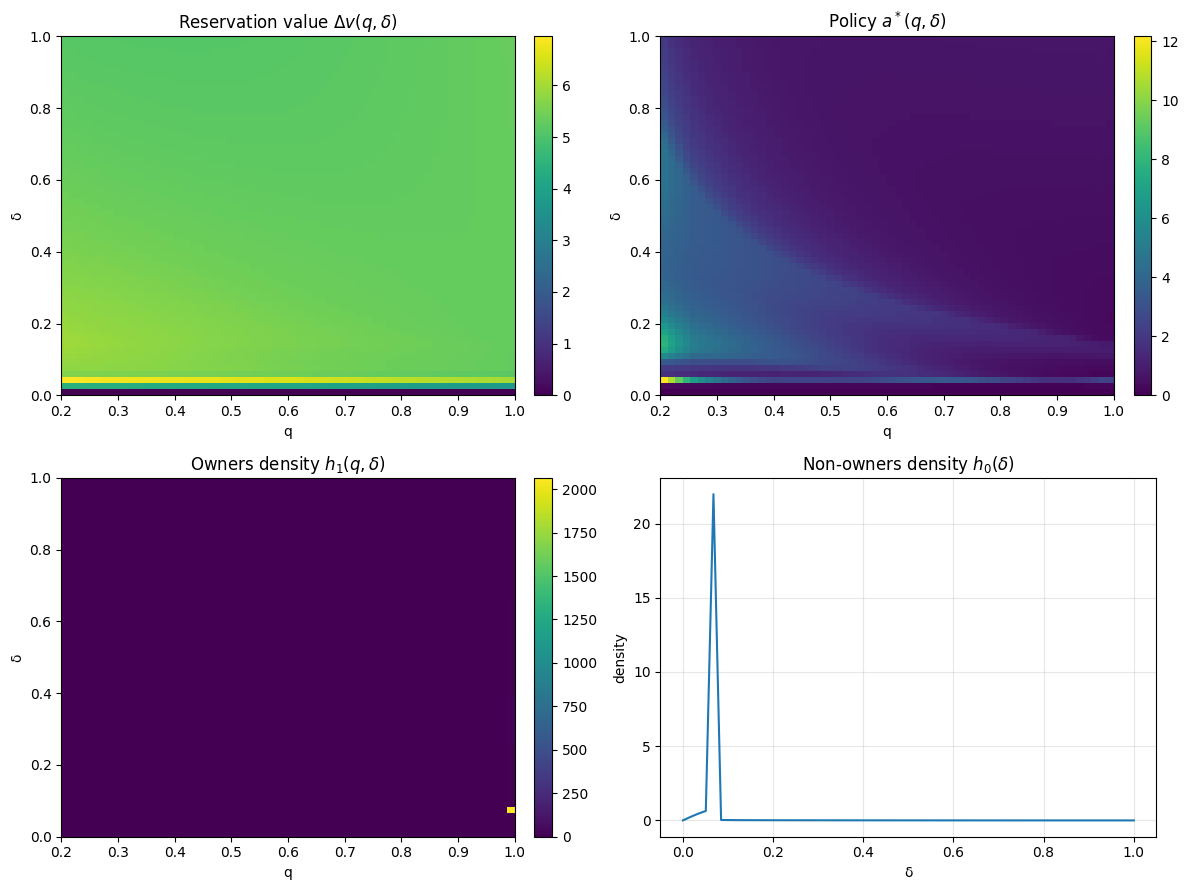

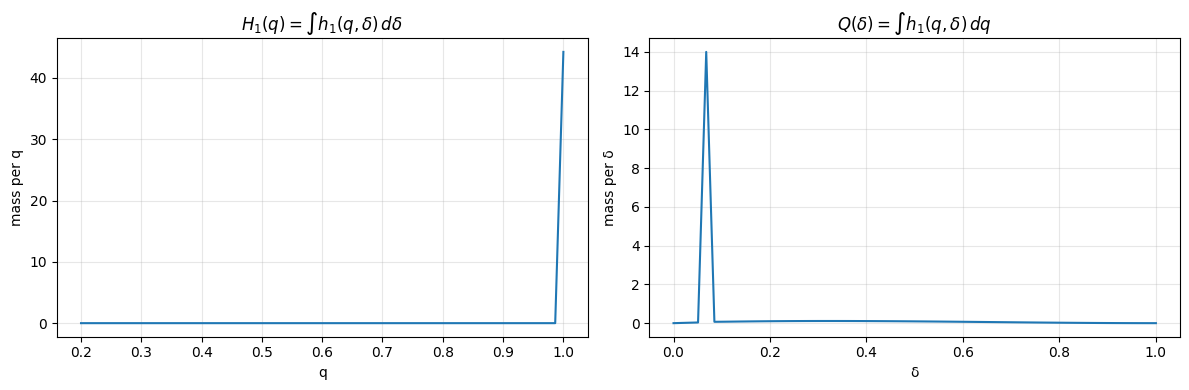

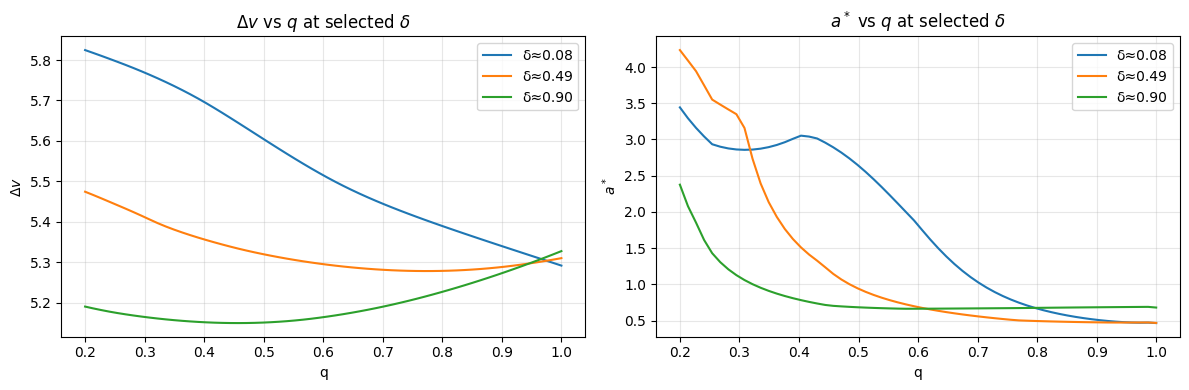

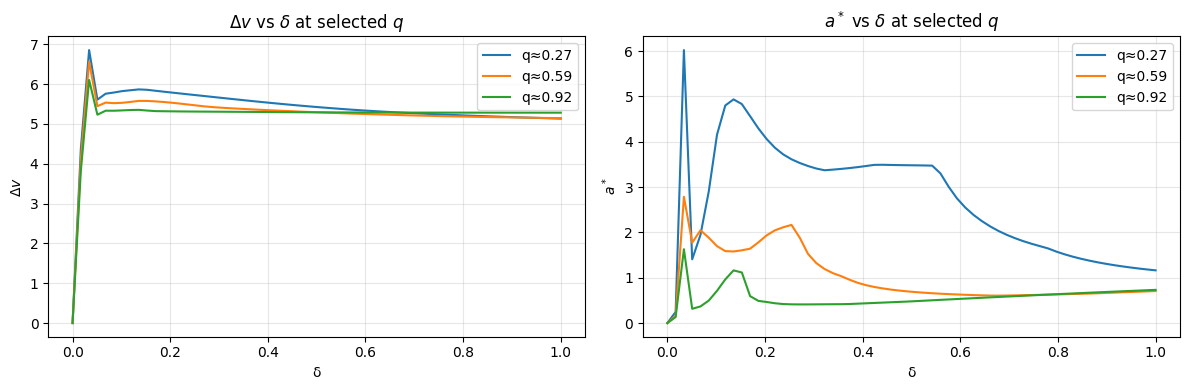

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# assumes p, res, Delta, a, h1, h0, q, dlt are already in memory
q = np.linspace(p.qmin, p.qmax, p.Nq)
dlt = np.linspace(p.dmin, p.dmax, p.Nd)
dq = (p.qmax - p.qmin) / (p.Nq - 1)
dd = (p.dmax - p.dmin) / (p.Nd - 1)

# --- Marginals with correct spacing
H1_q = np.trapezoid(h1, x=dlt, axis=1)      # ∫ h1(q,δ) dδ
Q_d  = np.trapezoid(h1, x=q,   axis=0)      # ∫ h1(q,δ) dq

# --- Mass with correct spacing
mass_h1 = np.trapezoid(np.trapezoid(h1, x=dlt, axis=1), x=q)
mass_h0 = np.trapezoid(h0, x=dlt)

print("Sanity checks (trapezoid):")
print("  Mass h1 ~", float(mass_h1))
print("  Mass h0 ~", float(mass_h0))
print("  Sum-based   h1 ~", float(h1.sum() * dq * dd))
print("  Sum-based   h0 ~", float(h0.sum() * dd))
print("  a* >= 0 ?  ->", np.all(a >= -1e-12))

# --- Monotonicity of Δv in δ (by q row)
dDelta_d = np.diff(Delta, axis=1)  # along δ
viol = dDelta_d < -1e-8
num_viol = int(viol.sum())
max_neg = float(np.min(dDelta_d))
print(f"  Δv monotone in δ? -> {num_viol==0}  (violations: {num_viol}, worst step {max_neg:.3e})")

# ---------- Plots (same as before, but now using updated marginals) ----------
def heat(ax, Z, title, xlabel="q", ylabel="δ"):
    extent = [q[0], q[-1], dlt[0], dlt[-1]]
    im = ax.imshow(Z.T, origin="lower", aspect="auto", extent=extent, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
heat(axs[0,0], Delta, r"Reservation value $\Delta v(q,\delta)$")
heat(axs[0,1], a,     r"Policy $a^*(q,\delta)$")
heat(axs[1,0], h1,    r"Owners density $h_1(q,\delta)$")
axs[1,1].plot(dlt, h0); axs[1,1].grid(alpha=0.3)
axs[1,1].set_title(r"Non-owners density $h_0(\delta)$"); axs[1,1].set_xlabel("δ"); axs[1,1].set_ylabel("density")
fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(q, H1_q); axs[0].grid(alpha=0.3)
axs[0].set_title(r"$H_1(q)=\int h_1(q,\delta)\,d\delta$"); axs[0].set_xlabel("q"); axs[0].set_ylabel("mass per q")
axs[1].plot(dlt, Q_d); axs[1].grid(alpha=0.3)
axs[1].set_title(r"$Q(\delta)=\int h_1(q,\delta)\,dq$"); axs[1].set_xlabel("δ"); axs[1].set_ylabel("mass per δ")
fig.tight_layout()

# Slices as before
quantiles = [0.1, 0.5, 0.9]
j_idx = [int(qt * (p.Nd - 1)) for qt in quantiles]
i_mid = p.Nq // 2

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for j in j_idx:
    axs[0].plot(q, Delta[:, j], label=f"δ≈{dlt[j]:.2f}")
axs[0].set_title(r"$\Delta v$ vs $q$ at selected $\delta$"); axs[0].set_xlabel("q"); axs[0].set_ylabel(r"$\Delta v$")
axs[0].grid(alpha=0.3); axs[0].legend()

for j in j_idx:
    axs[1].plot(q, a[:, j], label=f"δ≈{dlt[j]:.2f}")
axs[1].set_title(r"$a^*$ vs $q$ at selected $\delta$"); axs[1].set_xlabel("q"); axs[1].set_ylabel(r"$a^*$")
axs[1].grid(alpha=0.3); axs[1].legend()
fig.tight_layout()

i_idx = [int(x * (p.Nq - 1)) for x in (0.1, 0.5, 0.9)]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in i_idx:
    axs[0].plot(dlt, Delta[i, :], label=f"q≈{q[i]:.2f}")
axs[0].set_title(r"$\Delta v$ vs $\delta$ at selected $q$"); axs[0].set_xlabel("δ"); axs[0].set_ylabel(r"$\Delta v$")
axs[0].grid(alpha=0.3); axs[0].legend()

for i in i_idx:
    axs[1].plot(dlt, a[i, :], label=f"q≈{q[i]:.2f}")
axs[1].set_title(r"$a^*$ vs $\delta$ at selected $q$"); axs[1].set_xlabel("δ"); axs[1].set_ylabel(r"$a^*$")
axs[1].grid(alpha=0.3); axs[1].legend()
fig.tight_layout()


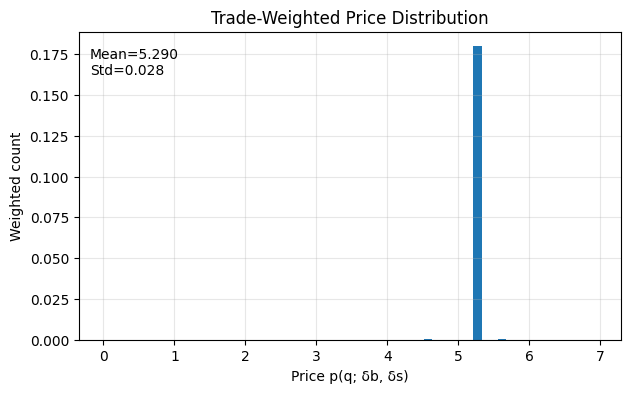

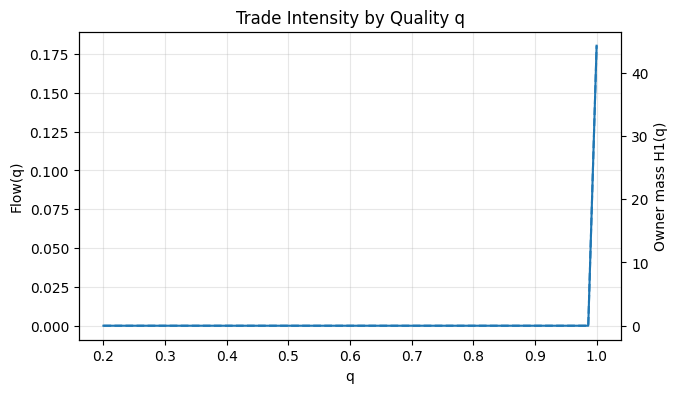

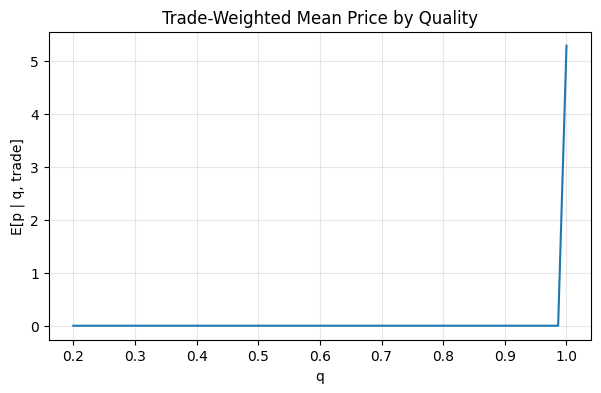

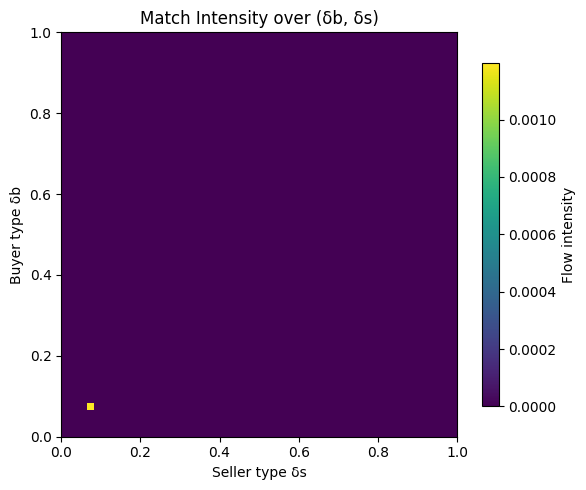


--- Trade & Price Diagnostics ---
Total trade flow: 0.18028523173311437
Mean price: 5.290459867086609
Std of price: 0.02768906957148118
Acceptance region share (δb ≥ δs): 0.5083333333333333


In [15]:
# === Trade & Price Diagnostics (NumPy 2.0–compliant) ===
import numpy as np
import matplotlib.pyplot as plt

Delta = res["Delta"]; a = res["a"]; h1 = res["h1"]; h0 = res["h0"]
Nq, Nd = Delta.shape
q   = np.linspace(p.qmin, p.qmax, Nq)
dlt = np.linspace(p.dmin, p.dmax, Nd)
wq  = (p.qmax - p.qmin) / (Nq - 1)
wd  = (p.dmax - p.dmin) / (Nd - 1)

def Int_q(f_q):     return np.trapezoid(f_q, x=q, axis=0)
def Int_delta(f_d): return np.trapezoid(f_d, x=dlt, axis=0)
def Int_both(f_qd): return np.trapezoid(np.trapezoid(f_qd, x=dlt, axis=1), x=q)

# 1) Trade-weighted price distribution
Delta_b = Delta[:, :, None]
Delta_s = Delta[:, None, :]
price = 0.5 * (Delta_b + Delta_s)
Jb, Js = np.meshgrid(np.arange(Nd), np.arange(Nd), indexing='ij')
accept = (Jb >= Js).astype(float)[None, :, :]
h0_b = h0[None, :, None]
h1_s = h1[:, None, :]
W = (p.rho/2.0) * accept * h0_b * h1_s * wq * wd * wd

Pmin, Pmax = np.min(price), np.max(price)
bins = 60
hist_w, bin_edges = np.histogram(price.ravel(), bins=bins, range=(Pmin, Pmax),
                                 weights=W.ravel(), density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
fig1, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(bin_centers, hist_w, width=(bin_edges[1]-bin_edges[0]))
ax1.set_title("Trade-Weighted Price Distribution")
ax1.set_xlabel("Price p(q; δb, δs)")
ax1.set_ylabel("Weighted count")
ax1.grid(True, alpha=0.3)

total_flow = float(W.sum())
if total_flow > 0:
    mean_price = float((price * W).sum() / total_flow)
    var_price = float(((price - mean_price)**2 * W).sum() / total_flow)
    ax1.text(0.02, 0.95, f"Mean={mean_price:.3f}\nStd={np.sqrt(var_price):.3f}",
             transform=ax1.transAxes, va='top', ha='left')

# 2) Trade intensity over q
flow_q = np.sum(W, axis=(1,2))
fig2, ax2 = plt.subplots(figsize=(7,4))
ax2.plot(q, flow_q)
ax2.set_title("Trade Intensity by Quality q")
ax2.set_xlabel("q"); ax2.set_ylabel("Flow(q)")
ax2.grid(True, alpha=0.3)
H1_q = np.trapezoid(h1, x=dlt, axis=1)
ax2_t = ax2.twinx()
ax2_t.plot(q, H1_q, linestyle='--')
ax2_t.set_ylabel("Owner mass H1(q)")

# 3) Mean price by q
W_q = W.sum(axis=(1,2))
num_q = (price * W).sum(axis=(1,2))
mean_p_q = np.divide(num_q, W_q, out=np.zeros_like(num_q), where=W_q>0)
fig3, ax3 = plt.subplots(figsize=(7,4))
ax3.plot(q, mean_p_q)
ax3.set_title("Trade-Weighted Mean Price by Quality")
ax3.set_xlabel("q"); ax3.set_ylabel("E[p | q, trade]")
ax3.grid(True, alpha=0.3)

# 4) Match intensity over (δb, δs)
W_qint = np.trapezoid(W, x=q, axis=0)
fig4, ax4 = plt.subplots(figsize=(6,5))
im = ax4.imshow(W_qint, origin='lower', extent=[dlt[0], dlt[-1], dlt[0], dlt[-1]], aspect='auto')
ax4.set_title("Match Intensity over (δb, δs)")
ax4.set_xlabel("Seller type δs"); ax4.set_ylabel("Buyer type δb")
fig4.colorbar(im, ax=ax4, shrink=0.85, label="Flow intensity")
plt.tight_layout(); plt.show()

print("\n--- Trade & Price Diagnostics ---")
print("Total trade flow:", total_flow)
if total_flow > 0:
    print("Mean price:", mean_price)
    print("Std of price:", np.sqrt(var_price))
print("Acceptance region share (δb ≥ δs):", float(np.mean(Jb >= Js)))


In [16]:
# === Moments & Correlations (owners, policy, prices, trades) ===
import numpy as np

Delta = res["Delta"]; a = res["a"]; h1 = res["h1"]; h0 = res["h0"]
Nq, Nd = Delta.shape
q   = np.linspace(p.qmin, p.qmax, Nq)
dlt = np.linspace(p.dmin, p.dmax, Nd)
wq  = (p.qmax - p.qmin) / (Nq - 1)
wd  = (p.dmax - p.dmin) / (Nd - 1)

def Int_q(f_q):     return np.trapezoid(f_q, x=q, axis=0)
def Int_delta(f_d): return np.trapezoid(f_d, x=dlt, axis=0)
def Int_both(f_qd): return np.trapezoid(np.trapezoid(f_qd, x=dlt, axis=1), x=q)

def weighted_mean(f, w):
    m = np.sum(f * w)
    Z = np.sum(w)
    return m / Z if Z > 0 else np.nan

def weighted_var(f, w):
    mu = weighted_mean(f, w)
    return weighted_mean((f - mu)**2, w)

def weighted_corr(x, y, w):
    mu_x = weighted_mean(x, w); mu_y = weighted_mean(y, w)
    cov = weighted_mean((x - mu_x)*(y - mu_y), w)
    vx  = weighted_var(x, w); vy = weighted_var(y, w)
    if vx <= 0 or vy <= 0: return np.nan
    return cov / np.sqrt(vx*vy)

# ---- Owner cross-section (weights = h1 dq dδ) ----
W_own = h1 * wq * wd                             # shape (Nq, Nd)
Qmat  = q[:, None] * np.ones((1, Nd))
Dmat  = np.ones((Nq, 1)) * dlt[None, :]
kappa_q = p.kappa0 * q
Kmat  = kappa_q[:, None]

# Owner means/vars
E_q_own  = weighted_mean(Qmat, W_own)
V_q_own  = weighted_var(Qmat, W_own)
E_d_own  = weighted_mean(Dmat, W_own)
V_d_own  = weighted_var(Dmat, W_own)
Corr_qd_own = weighted_corr(Qmat, Dmat, W_own)

# Policy moments among owners
E_a_own   = weighted_mean(a, W_own)
V_a_own   = weighted_var(a, W_own)
Corr_aq   = weighted_corr(a, Qmat, W_own)
Corr_ad   = weighted_corr(a, Dmat, W_own)

# Owner flow “consumption” c(q,δ) = δ q - 0.5 κ(q) a^2
c_flow = Dmat * Qmat - 0.5 * Kmat * (a**2)
C_total = np.sum(c_flow * W_own)               # aggregate owner flow utility
C_per_owner = C_total / (p.s + 1e-16)          # per owner (mass s)
C_per_capita = C_total                          # per unit mass of economy if h1 already integrates to s

# ---- Trade objects (prices, flows) ----
# price p = 0.5(Δ(q,δ_b) + Δ(q,δ_s)), accept if δ_b >= δ_s
Delta_b = Delta[:, :, None]                # (Nq, Nd, 1)
Delta_s = Delta[:, None, :]                # (Nq, 1, Nd)
price   = 0.5 * (Delta_b + Delta_s)        # (Nq, Nd_b, Nd_s)

Jb, Js  = np.meshgrid(np.arange(Nd), np.arange(Nd), indexing='ij')
accept  = (Jb >= Js).astype(float)[None, :, :]  # (1, Nd, Nd)

h0_b = h0[None, :, None]                   # (1, Nd, 1)
h1_s = h1[:, None, :]                      # (Nq, 1, Nd)
Wtrade = (p.rho/2.0) * accept * h0_b * h1_s * wq * wd * wd  # weights for trades

total_trade_flow = float(np.sum(Wtrade))

# Trade-weighted moments
# (Flatten everything with same shape)
Pvec  = price.ravel()
Qvec  = np.repeat(q, Nd*Nd)                # quality at each price cell
Dbvec = np.tile(np.repeat(dlt, Nd), Nq)    # buyer type
Dsvec = np.tile(np.tile(dlt, Nd), Nq)      # seller type
Wvec  = Wtrade.ravel()

def tw_mean(x): return weighted_mean(x, Wvec)
def tw_var(x):  return weighted_var(x, Wvec)
def tw_corr(x, y): return weighted_corr(x, y, Wvec)

P_mean   = tw_mean(Pvec)
P_std    = np.sqrt(tw_var(Pvec)) if total_trade_flow > 0 else np.nan
Q_mean_tr= tw_mean(Qvec)
Db_mean  = tw_mean(Dbvec)
Ds_mean  = tw_mean(Dsvec)

Corr_PQ   = tw_corr(Pvec, Qvec)
Corr_PDb  = tw_corr(Pvec, Dbvec)
Corr_PDs  = tw_corr(Pvec, Dsvec)
Corr_DbDs = tw_corr(Dbvec, Dsvec)

# Conditional dispersion: std of price by quality, then average across q (trade-weighted by flow at q)
Wq = np.sum(Wtrade, axis=(1,2))                           # trade flow by q (Nq,)
num_q = np.sum(price * Wtrade, axis=(1,2))
mean_p_q = np.divide(num_q, Wq, out=np.zeros_like(num_q), where=Wq>0)
sqdev_q = np.sum((price - mean_p_q[:, None, None])**2 * Wtrade, axis=(1,2))
var_p_q = np.divide(sqdev_q, Wq, out=np.zeros_like(sqdev_q), where=Wq>0)
avg_std_p_by_q = float(weighted_mean(np.sqrt(var_p_q), Wq))

# ---- Print summary ----
print("\n=== Moments & Correlations ===")
print("Owner mass (∑ h1 dq dδ):      ", float(np.sum(W_own)))
print("Non-owner mass (∑ h0 dδ):     ", float(np.trapezoid(h0, x=dlt)))
print("\n-- Owners cross-section --")
print(f"E[q] = {E_q_own:.4f},  Std[q] = {np.sqrt(V_q_own):.4f}")
print(f"E[δ] = {E_d_own:.4f},  Std[δ] = {np.sqrt(V_d_own):.4f}")
print(f"Corr(q, δ) = {Corr_qd_own:.4f}")
print("\n-- Policy a(q,δ) among owners --")
print(f"E[a] = {E_a_own:.4f},  Std[a] = {np.sqrt(V_a_own):.4f}")
print(f"Corr(a, q) = {Corr_aq:.4f},  Corr(a, δ) = {Corr_ad:.4f}")
print("\n-- Owner flow consumption --")
print(f"Aggregate owner flow C = {C_total:.5f}")
print(f"Per owner C/s = {C_per_owner:.5f}")
print(f"Per capita (owner flow; mass-weighted) ≈ {C_per_capita:.5f}")
print("\n-- Trade-weighted moments --")
print(f"Total trade flow = {total_trade_flow:.6f}")
print(f"E[p] = {P_mean:.5f},  Std[p] = {P_std:.5f}")
print(f"E[q | trade] = {Q_mean_tr:.5f}")
print(f"E[δ_b | trade] = {Db_mean:.5f},  E[δ_s | trade] = {Ds_mean:.5f}")
print(f"Corr(p, q) = {Corr_PQ:.4f},  Corr(p, δ_b) = {Corr_PDb:.4f},  Corr(p, δ_s) = {Corr_PDs:.4f}")
print(f"Corr(δ_b, δ_s) = {Corr_DbDs:.4f}  (sorting in matches)")
print(f"Avg. within-q price std (trade-weighted) = {avg_std_p_by_q:.5f}")



=== Moments & Correlations ===
Owner mass (∑ h1 dq dδ):       0.5999999999999999
Non-owner mass (∑ h0 dδ):      0.39999999999999986

-- Owners cross-section --
E[q] = 1.0000,  Std[q] = 0.0000
E[δ] = 0.1366,  Std[δ] = 0.1618
Corr(q, δ) = nan

-- Policy a(q,δ) among owners --
E[a] = 0.3392,  Std[a] = 0.1177
Corr(a, q) = nan,  Corr(a, δ) = 0.5388

-- Owner flow consumption --
Aggregate owner flow C = 0.04332
Per owner C/s = 0.07221
Per capita (owner flow; mass-weighted) ≈ 0.04332

-- Trade-weighted moments --
Total trade flow = 0.180285
E[p] = 5.29046,  Std[p] = 0.02769
E[q | trade] = 1.00000
E[δ_b | trade] = 0.07088,  E[δ_s | trade] = 0.06785
Corr(p, q) = nan,  Corr(p, δ_b) = 0.0300,  Corr(p, δ_s) = 0.0888
Corr(δ_b, δ_s) = 0.3266  (sorting in matches)
Avg. within-q price std (trade-weighted) = 0.02769
